Import modules

In [2]:
import jsonlines
import collections
import tqdm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14,
                     "font.family": "sans-serif",
                     "figure.figsize": (15, 6),
                     "axes.facecolor": "212121",
                     "figure.dpi"       : 200,
                     "legend.fontsize"  : "medium",
                     "figure.titlesize" : "medium",
                     "lines.linewidth": 2,
})

Functions to visualize statistics

In [3]:
def functionals(arr: np.ndarray) -> list[float]:
  mean = np.mean(arr)
  min = np.min(arr)
  max = np.max(arr)
  std = np.std(arr)
  median = np.median(arr)
  quantile75 = np.quantile(arr, 0.75)
  quantile90 = np.quantile(arr, 0.90)
  quantile95 = np.quantile(arr, 0.95)
  return [mean, std, min, max, median, quantile75, quantile90, quantile95]

def print_functionals(arr, desc):
  arr = np.array(arr)
  mean, std, min, max, med, q75, q90, q95 = functionals(arr)
  print(f"{desc}:")
  print(f"\t{'Mean +- std':20s}    = {mean:.2f} +- {std:.2f}")
  print(f"\t{'[Min, Max]':20s}    = [{min}, {max}]")
  print(f"\tquantiles: 50% (median) = {med:.2f}, 75% = {q75:.2f}, "
        f"90% = {q90:.2f}, 95% = {q95:.2f}")
  print()

def draw_histogram(arr, var="x", bins=10, disable_bar_labels=False, 
                   return_histogram=False, **kwargs):
  narr, bins, patches = plt.hist(arr, bins=bins, color="c", **kwargs)
  plt.xlabel(var)
  plt.ylabel("frequency")
  plt.title(f"Histogram of {var}")
  s = len(arr)

  if not disable_bar_labels:
    for i in range(len(patches)):
      xx = patches[i].get_x()
      height = patches[i].get_height()
      width = patches[i].get_width()
      text = f"[{bins[i]:.1f}, {bins[i + 1]:.1f})"
      if i == len(patches) - 1:
        text = f"[{bins[i]:.0f}, {bins[i + 1]:.0f}]"
      plt.text(xx + width/2, height, text, ha="center", va="bottom", 
              fontsize=12, color="w")
      plt.text(xx + width/2, height, f"{100*height/s:.1f}%", ha="center",
              va="top", fontsize=8, color="k")
  
  plt.show()

  if return_histogram:
    return narr, bins, patches

def describe(arr, desc, **kwargs):
  print_functionals(arr, desc)
  return draw_histogram(arr, var=desc, **kwargs)

Read data

In [4]:
movie_data = [d for d in jsonlines.open("/home/sbaruah_usc_edu/mica_text_coref/"
                                        "data/movie_coref/results/regular/"
                                        "movie.jsonlines")]

Print number of tokens, mentions and characters

In [5]:
for movie in movie_data:
    assert (len(movie["token"]) == len(movie["pos"]) == len(movie["ne"]) ==
            len(movie["parse"]) == len(movie["sentid"]) ==
            len(movie["speaker"])), ("Tokens, POS-tags, NER-tags, parse,"
                                    " sentence ids, and speaker sequences"
                                    " should have equal length")
    assert (len(movie["begin"]) == len(movie["end"]) ==
            len(movie["character"])), ("Mention begin ids, mention end ids, and"
                                       "character sequences should have equal"
                                       " length")
    n_tokens = len(movie["token"])
    n_mentions = len(movie["begin"])
    n_characters = len(set(movie["character"]))
    print(f"Movie = {movie['movie']}, Rater = {movie['rater']}")
    print(f"#Tokens = {n_tokens}, #Mentions = {n_mentions},"
          f" #Characters = {n_characters}")
    print()

Movie = avengers_endgame, Rater = prithvi
#Tokens = 35994, #Mentions = 5025, #Characters = 71

Movie = dead_poets_society, Rater = chakor
#Tokens = 26367, #Mentions = 3778, #Characters = 51

Movie = john_wick, Rater = prithvi
#Tokens = 24989, #Mentions = 2580, #Characters = 34

Movie = prestige, Rater = chakor
#Tokens = 36073, #Mentions = 5140, #Characters = 34

Movie = quiet_place, Rater = athashree
#Tokens = 27875, #Mentions = 2786, #Characters = 9

Movie = zootopia, Rater = athashree
#Tokens = 27249, #Mentions = 3677, #Characters = 113

Movie = shawshank, Rater = expert
#Tokens = 8116, #Mentions = 888, #Characters = 44

Movie = bourne, Rater = expert
#Tokens = 8119, #Mentions = 911, #Characters = 39

Movie = basterds, Rater = expert
#Tokens = 7815, #Mentions = 1008, #Characters = 23



Calculate statistics

In [6]:
n_characters = 0
n_singleton_characters = 0
cluster_lengths = []
distance_between_antecedents = []
scene_lengths = []
scene_description_lengths = []
utterance_lengths = []
n_mentions_per_cluster = []

for movie in movie_data:
    tokens = movie["token"]
    character_to_cluster = collections.defaultdict(set)

    for begin, end, character in tqdm.tqdm(
        zip(movie["begin"], movie["end"], movie["character"]),
        total=len(movie["begin"]),
        desc=f"Creating clusters for {movie['movie']}"):
        mention = (begin, end)
        key = f"{movie}_{character}"
        character_to_cluster[key].add(mention)

    for cluster in character_to_cluster.values():
        sorted_cluster = sorted(cluster)
        n_characters += 1
        n_mentions_per_cluster.append(len(sorted_cluster))
        if len(sorted_cluster) == 1:
            n_singleton_characters += 1
        else:
            cluster_length = sorted_cluster[-1][1] - sorted_cluster[0][0]
            cluster_lengths.append(cluster_length)
            for i in range(len(sorted_cluster) - 1):
                mention = sorted_cluster[i]
                next_mention = sorted_cluster[i + 1]
                distance = next_mention[1] - mention[0]
                distance_between_antecedents.append(distance)

    tags = movie["parse"]
    current_scene_length = 0
    i = 0
    found_content_tag = False
    while i < len(tags):
        if tags[i] == "S":
            if found_content_tag:
                scene_lengths.append(current_scene_length)
            j = i + 1
            while j < len(tags) and tags[j] == "S":
                j += 1
            current_scene_length = j - i
            found_content_tag = False
            i = j
        else:
            if tags[i] in ["N", "D"]:
                found_content_tag = True
            current_scene_length += 1
            i += 1
    if found_content_tag:
        scene_lengths.append(current_scene_length)
    
    i = 0
    while i < len(tags):
        if tags[i] in ["N", "D"]:
            j = i + 1
            while j < len(tags) and tags[j] == tags[i]:
                j += 1
            if tags[i] == "N":
                scene_description_lengths.append(j - i)
            else:
                utterance_lengths.append(j - i)
            i = j
        else:
            i += 1

Creating clusters for basterds: 100%|██████████| 1008/1008 [00:02<00:00, 362.96it/s]


In [7]:
print(f"Total number of characters = {n_characters}")
print(f"Total number of singleton characters = {n_singleton_characters}")

Total number of characters = 418
Total number of singleton characters = 65


Number of tokens between the first and last mention of a coreference chain

Number of tokens between the first and last mention of a coreference chain:
	Mean +- std             = 10114.56 +- 12224.39
	[Min, Max]              = [1, 36030]
	quantiles: 50% (median) = 3256.00, 75% = 22091.00, 90% = 32504.60, 95% = 33387.40



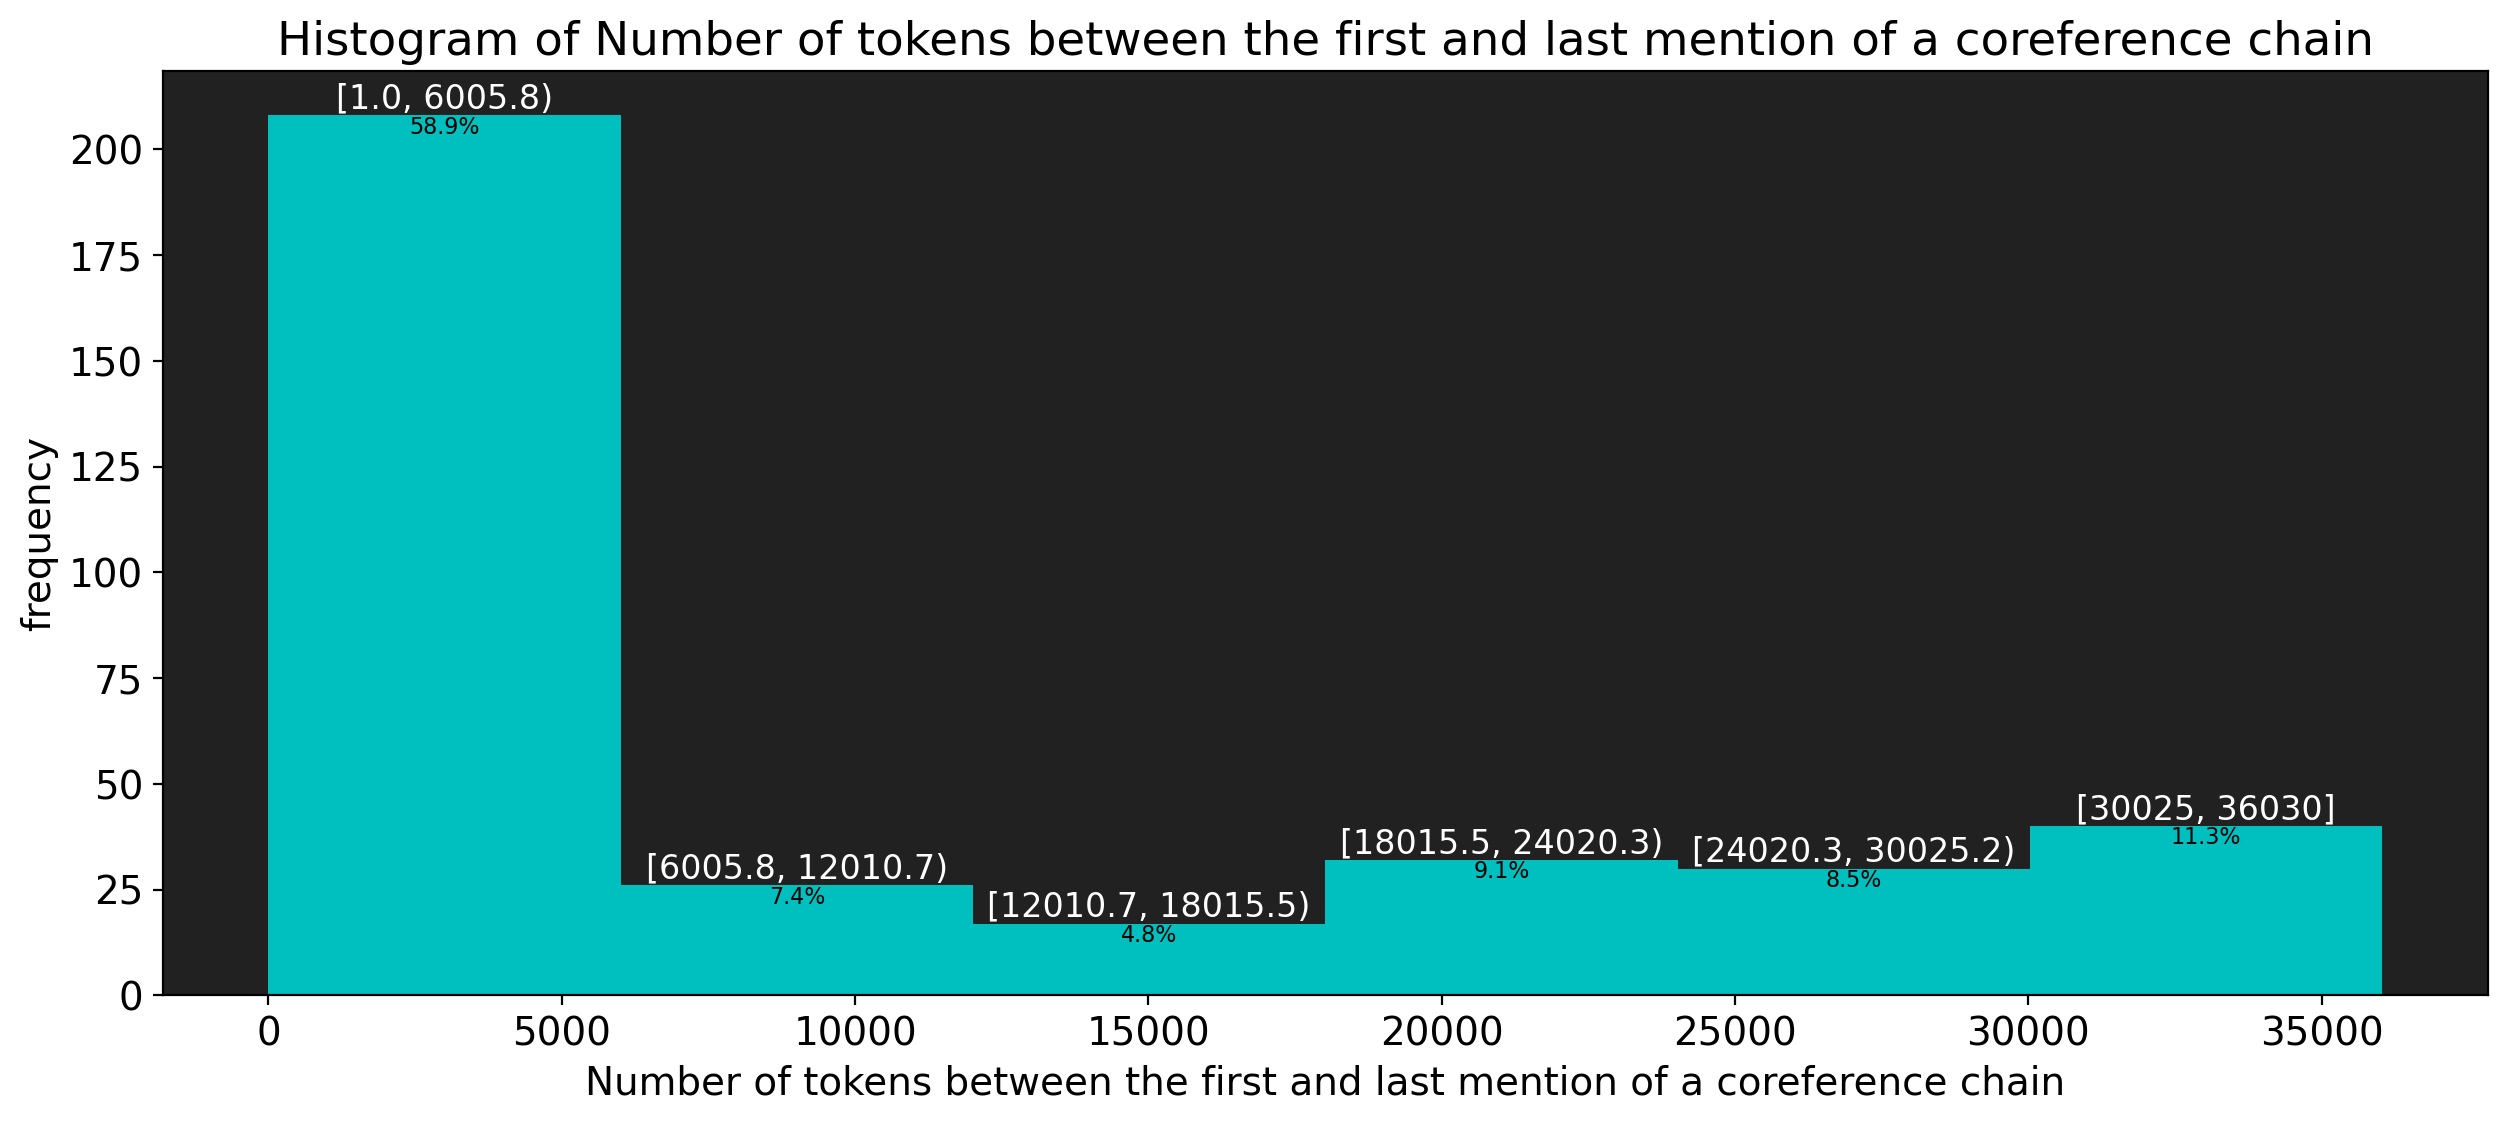

In [9]:
describe(cluster_lengths,
         desc=("Number of tokens between the first and last mention of a"
               " coreference chain"),
        bins="fd")

Number of tokens between successive co-referring mentions

Number of tokens between successive co-referring mentions (95%):
	Mean +- std             = 23.23 +- 35.77
	[Min, Max]              = [1, 281]
	quantiles: 50% (median) = 11.00, 75% = 24.00, 90% = 51.00, 95% = 90.00



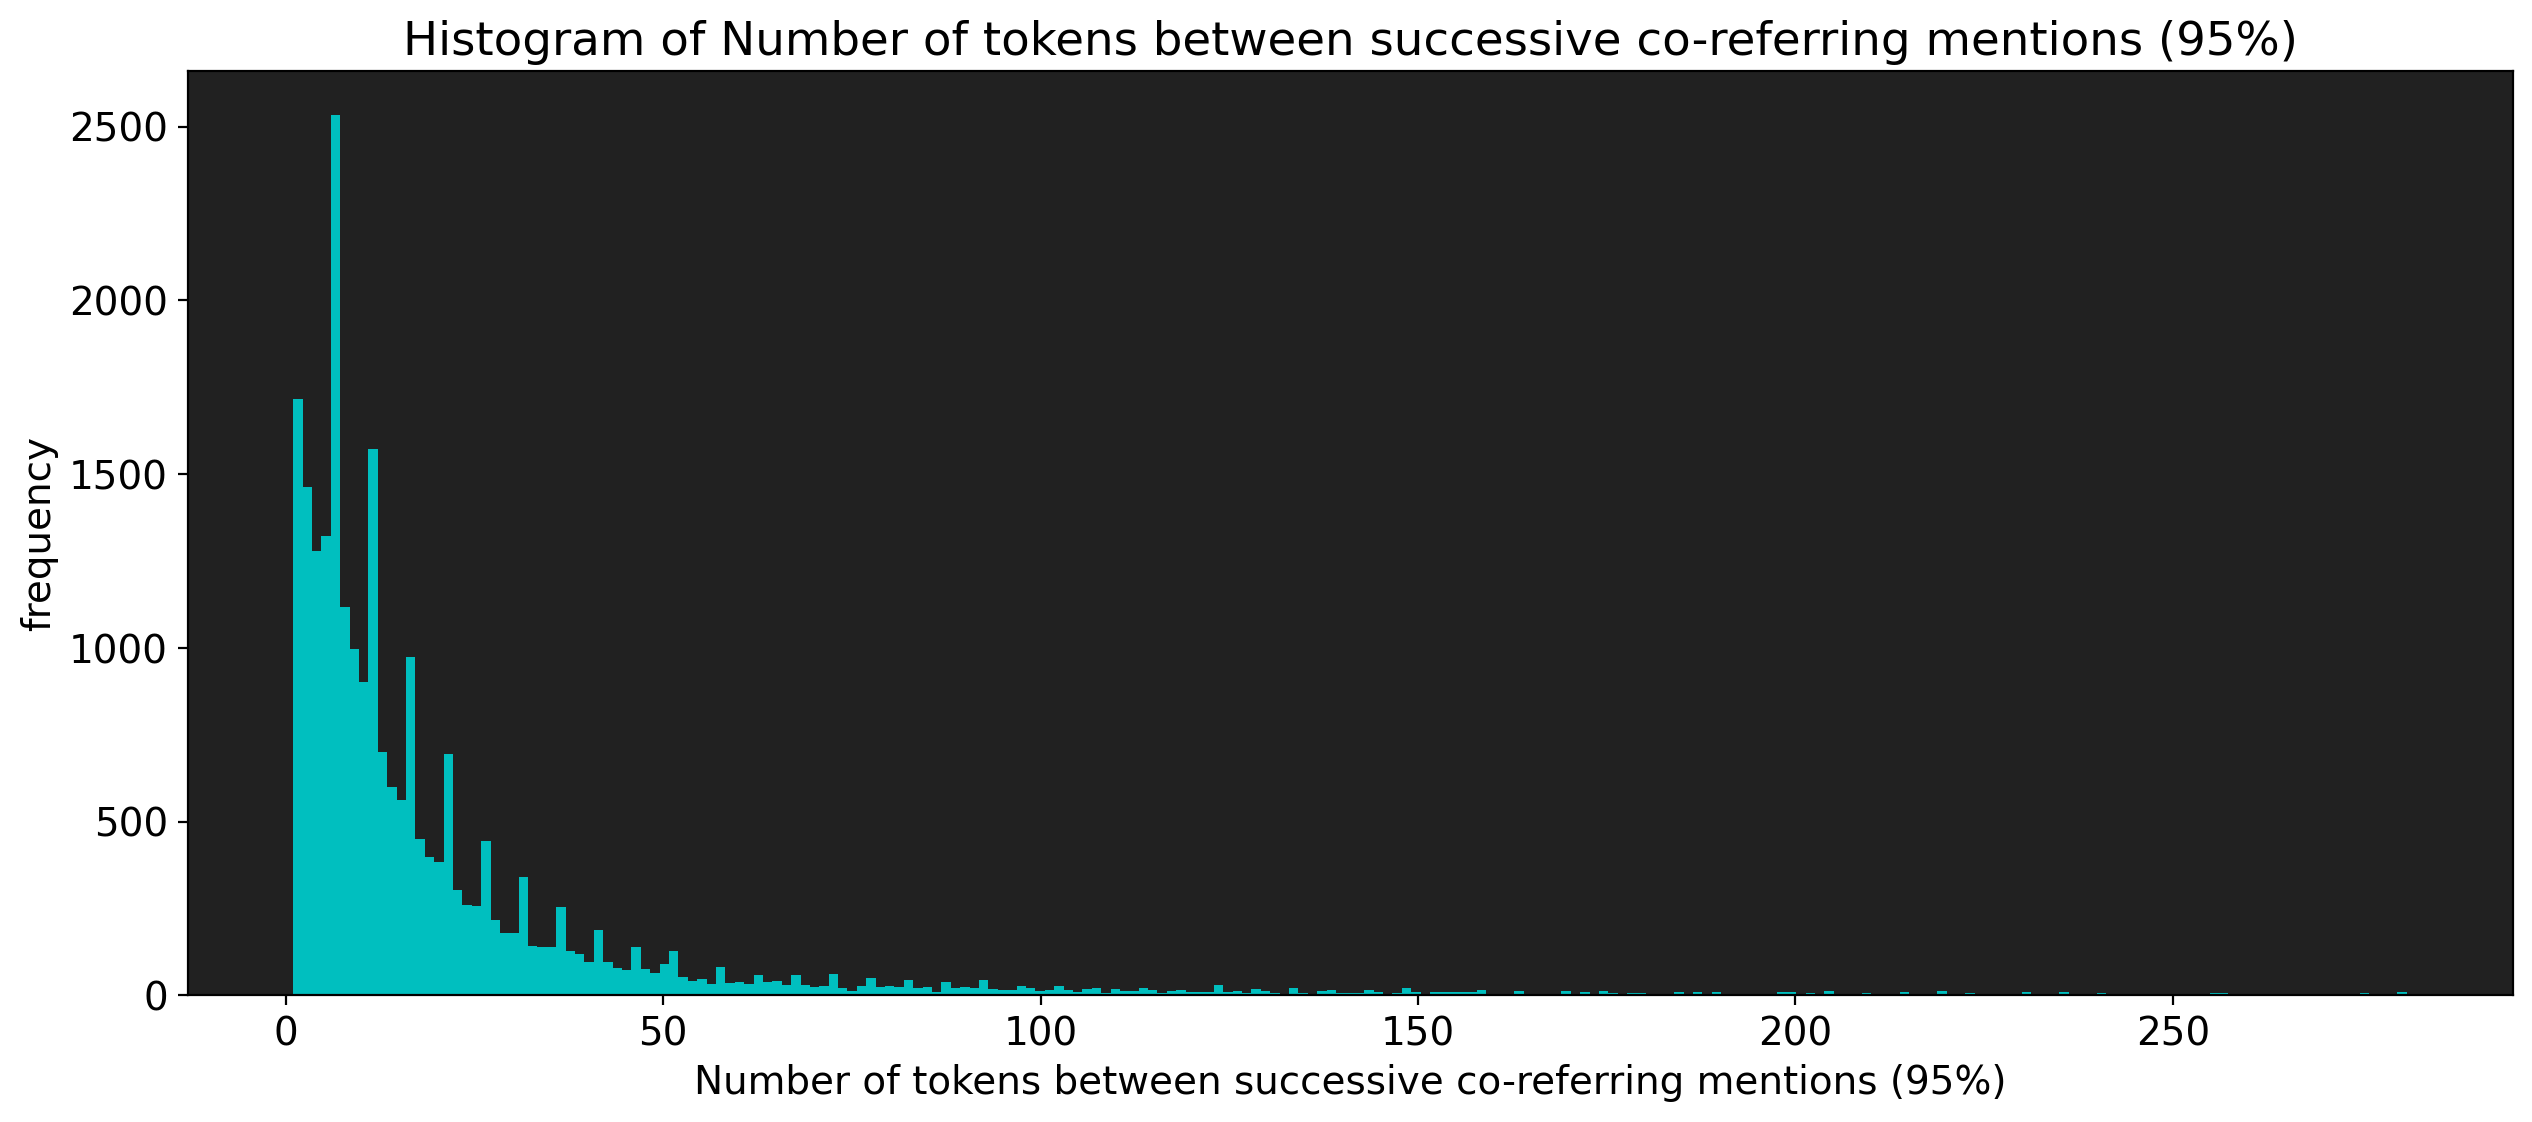

In [17]:
from faulthandler import disable


x = np.array(distance_between_antecedents)
x = x[x < np.quantile(x, 0.95)]
describe(x,
         desc="Number of tokens between successive co-referring mentions (95%)",
         bins="fd", disable_bar_labels=True)

Number of mentions per cluster

Number of mentions per cluster (90%):
	Mean +- std             = 19.85 +- 29.61
	[Min, Max]              = [1, 155]
	quantiles: 50% (median) = 7.00, 75% = 22.00, 90% = 62.00, 95% = 79.00



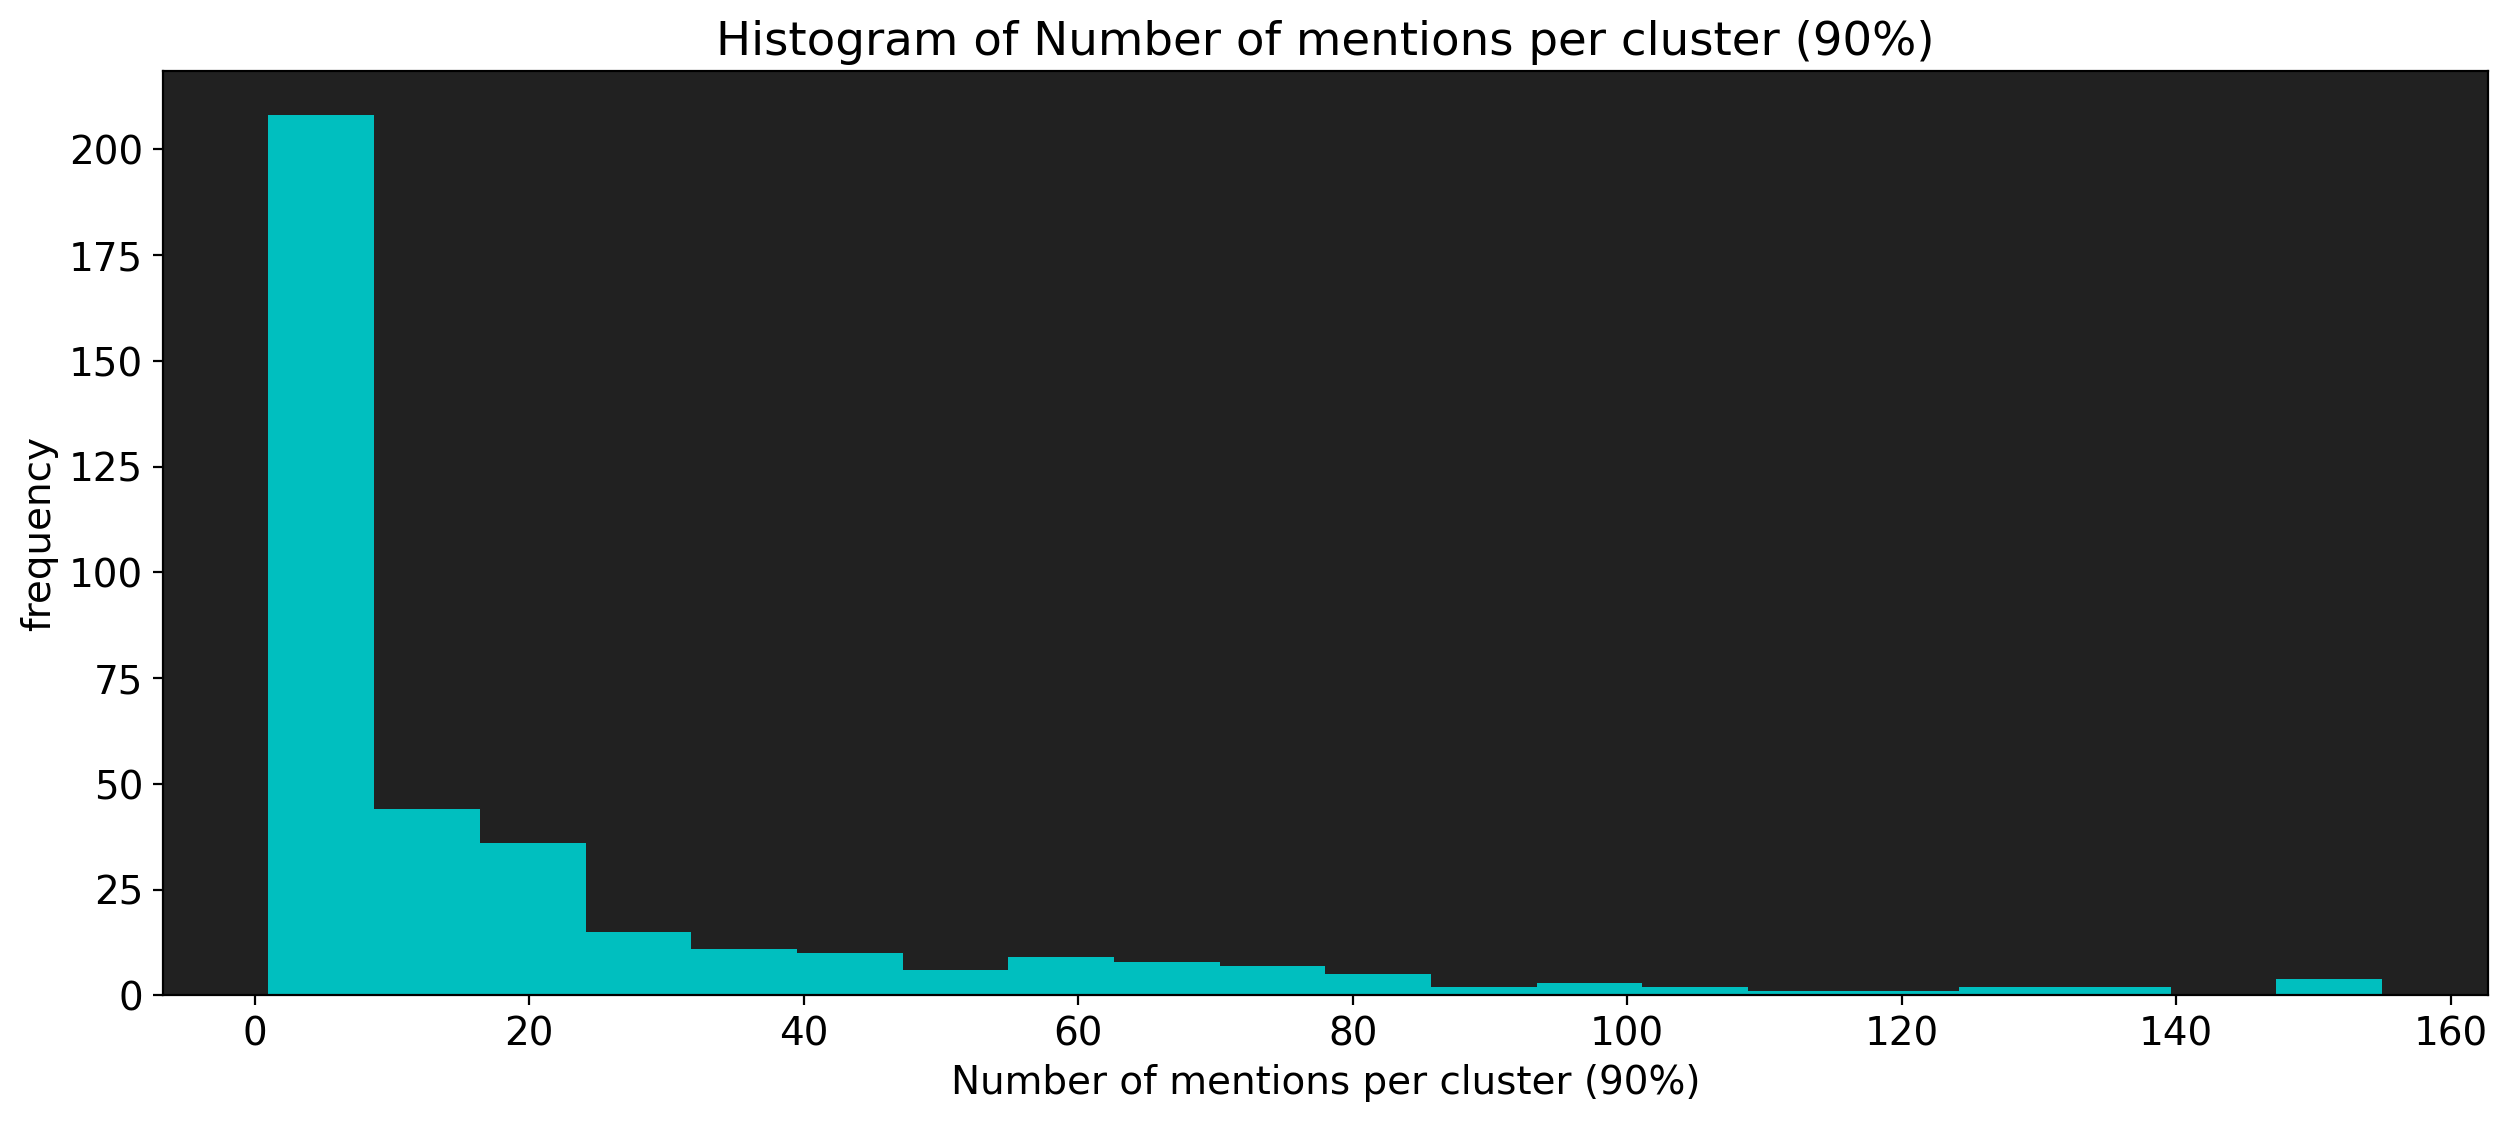

In [25]:
x = np.array(n_mentions_per_cluster)
x = x[x < np.quantile(x, 0.90)]
describe(x, desc="Number of mentions per cluster (90%)",
         bins=20, disable_bar_labels=True)

Scene lengths

Number of tokens per scene:
	Mean +- std             = 174.16 +- 234.19
	[Min, Max]              = [7, 3281]
	quantiles: 50% (median) = 85.00, 75% = 208.50, 90% = 424.00, 95% = 642.60



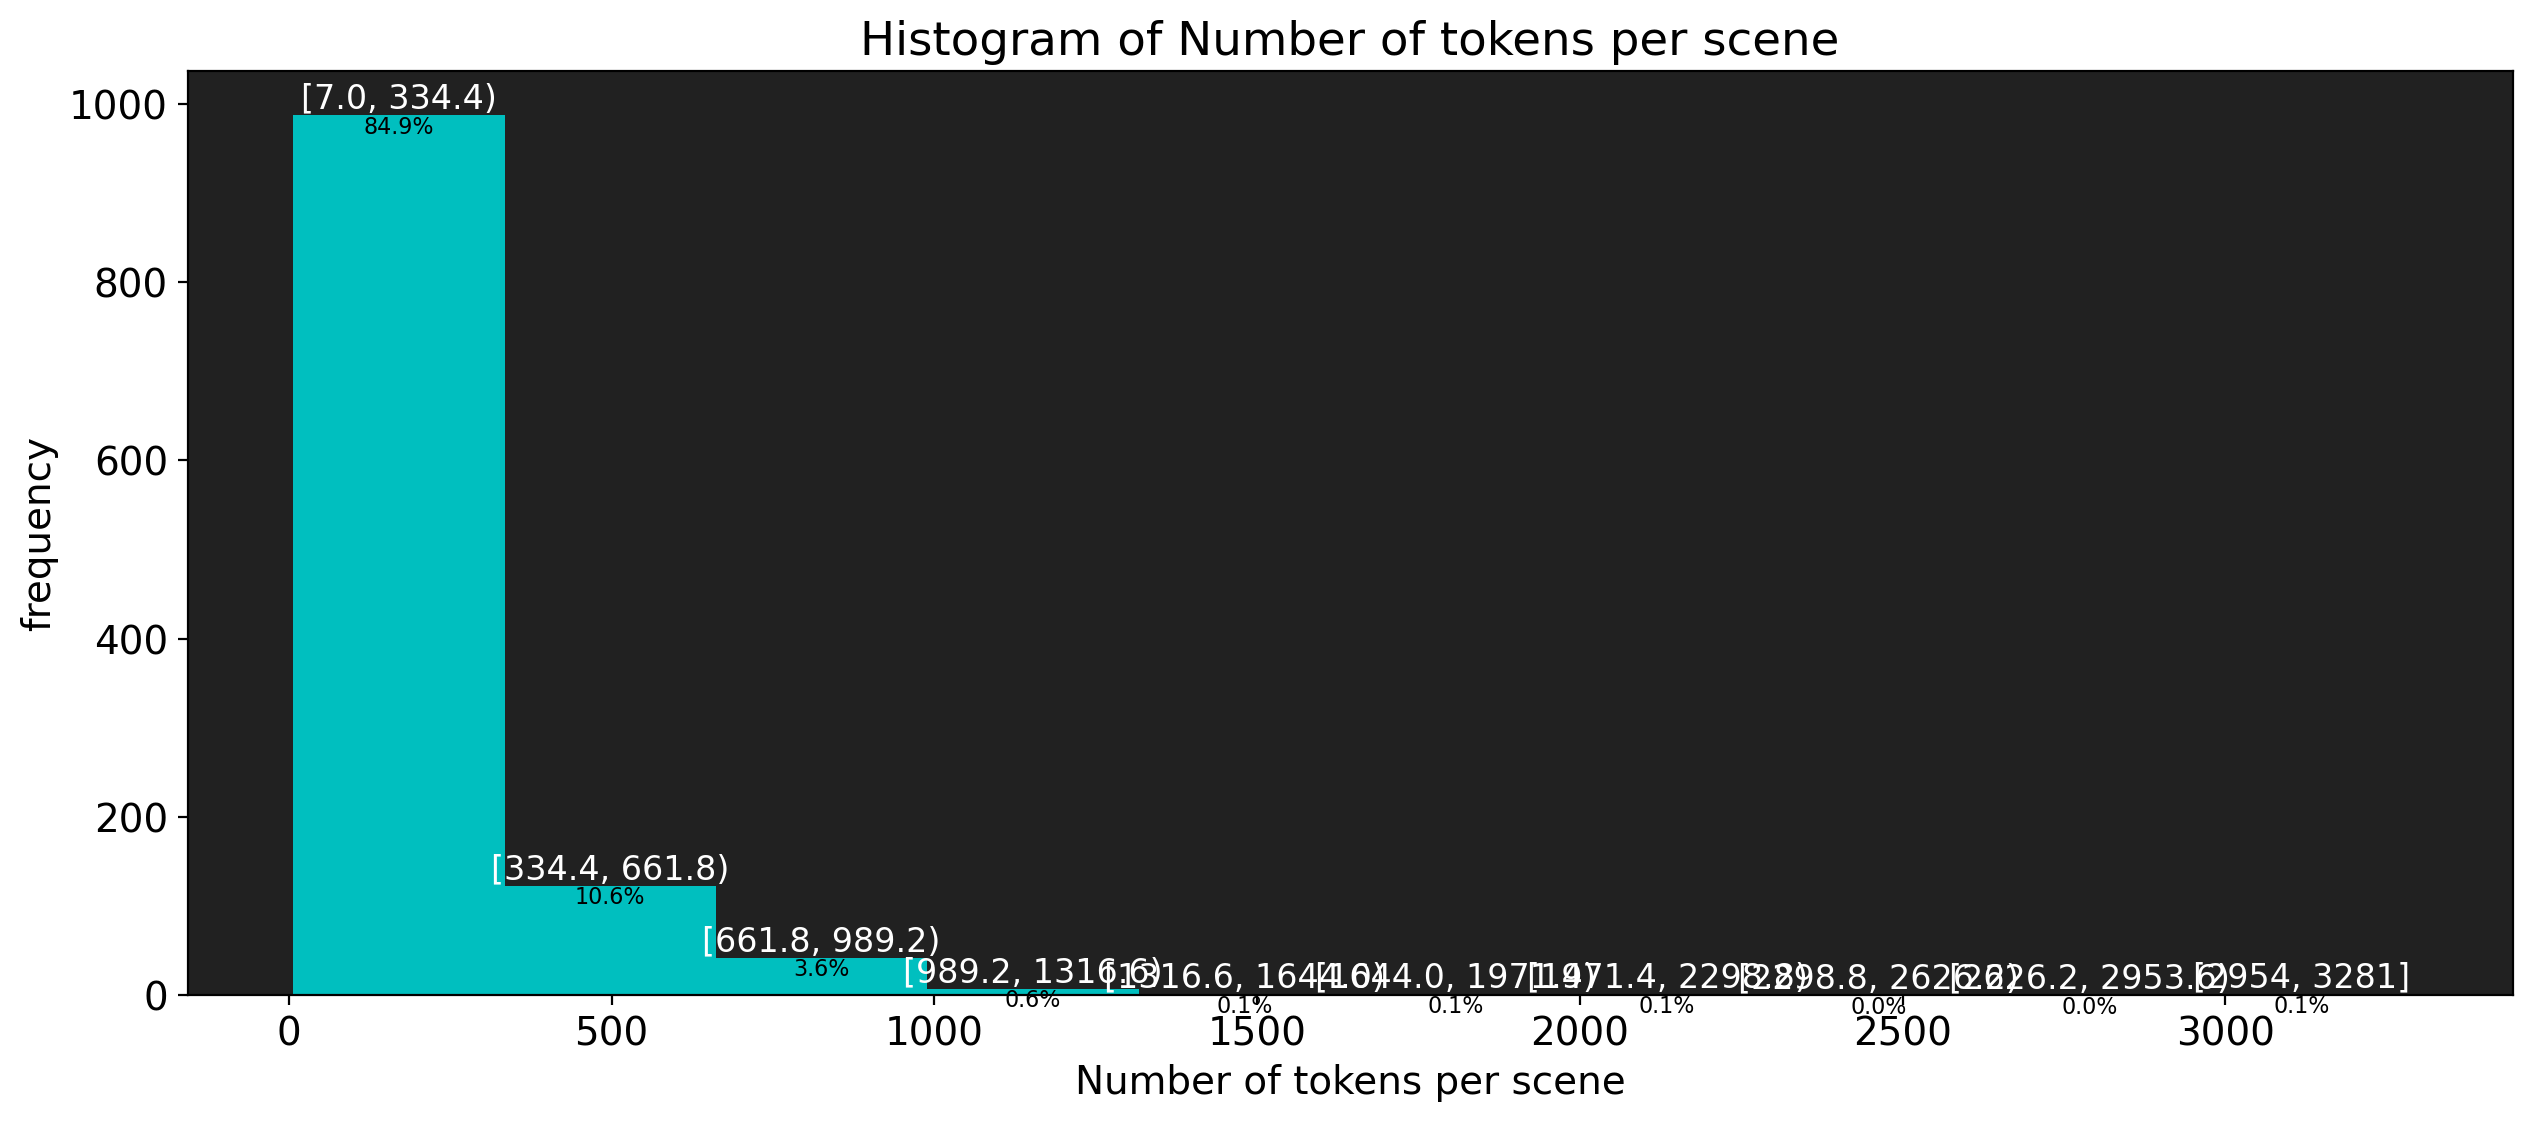

In [27]:
describe(scene_lengths,
         desc="Number of tokens per scene")